In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### Пытаемся численно решить неустойчивую задачу

Необходимо численно найти производную:
$$
\frac{\partial}{\partial x} k(x) \frac{\partial u}{\partial x} = f(x).
$$
То есть мы как бы решаем задачу обратную решению дифференциального уравнения типа теплопроводности - восстанавливаем f по u. В частности, далее расмматривается функция

In [2]:
def k(x):
    return 0.5

def u(x):
    if x <= 0.5:
        return - x**3 / 3 + x / 3
    else:
        return - x**2 / 2 + x / 2

Которой, как несложно убедиться, соответствует правая часть:

In [3]:
def f(x):
    if x <= 0.5:
        return x
    else:
        return 0.5

Попробуем вычислить производную численно:

In [4]:
u = np.vectorize(u)
f = np.vectorize(f)


def second_derivative(u_sd, x, n, k):
    h = 1. / n
    return -(k(x + h / 2) * (u_sd(x + h) - u_sd(x)) / h - k(x - h / 2) * (u_sd(x) - u_sd(x - h)) / h) / h

Как видно, в точки разрыва график, предсказуемо, выглядит не очень, но, в целом, картинка неплохая:

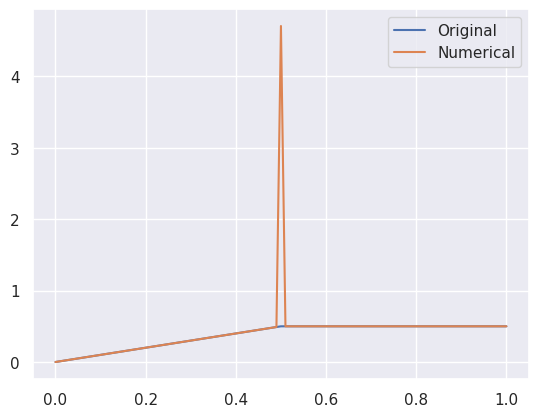

In [5]:
n = 101
grid = np.linspace(0, 1, n)

plt.plot(grid, f(grid), label="Original")
plt.plot(grid, second_derivative(u, grid, n, k), label="Numerical")
plt.legend()


Теперь внесем небольшую случайную погрешность:

In [6]:
EPSILON = 1e-3

def u2(x):
    def u(x):
        if x <= 0.5:
            return - x**3 / 3 + x / 3
        else:
            return - x**2 / 2 + x / 2
    rand_error = np.random.rand(1)
    u = np.vectorize(u)
    return u(x) + 2 * EPSILON * (rand_error - 0.5)

In [7]:
u2 = np.vectorize(u2)
f  = np.vectorize(f)

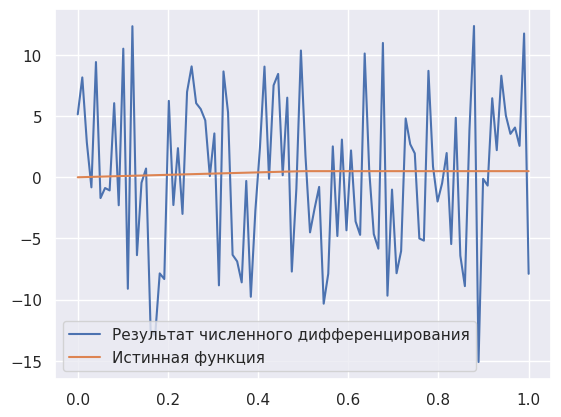

In [8]:
n = 100
grid = np.linspace(0, 1, n)

plt.plot(grid, second_derivative(u2, grid, n, k), label="Результат численного дифференцирования")
plt.plot(grid, f(grid), label="Истинная функция")
plt.legend()

Как видим, картинка совсем не похожа на оригинальную функцию. Попробуем быть чуть хитрее. Сначала запишем соответствующую матрицу:
$$
D = 
\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 & 0 \\
-\frac{k(x_i - h / 2)}{h^2} & \frac{k(x_i + h/2) + k(x_i - h/2)}{h^2} & -\frac{k(x_i + h / 2)}{h^2} & \cdots & 0 & 0 \\
0 & -\frac{k(x_i - h / 2)}{h^2} & \frac{k(x_i + h/2) + k(x_i - h/2)}{h^2} & -\frac{k(x_i + h / 2)}{h^2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & \cdots & 0 & -\frac{k(x_i - h / 2)}{h^2} & \frac{k(x_i + h/2) + k(x_i - h/2)}{h^2} & -\frac{k(x_i + h / 2)}{h^2} \\
0 & 0 & \cdots & 0 & 0 & 1 \\
\end{pmatrix}
$$.

In [9]:
n = 499
alpha = 1e-3
h = 1. / n

main_diag = np.array([(k(i * h + h / 2) + k(i * h - h / 2)) / (h**2) for i in range(n + 1)]) 
main_diag[0]  = 1
main_diag[-1] = 1

under_diag = np.array([- (k(i * h - h / 2)) / (h**2) for i in range(1, n + 1)]) 
under_diag[-1] = 0

upper_diag = np.array([- (k(i * h + h / 2)) / (h**2) for i in range(0, n)]) 
upper_diag[0] = 0

D = np.diag(main_diag)
for i in range(n):
    D[i, i + 1] = upper_diag[i]
    D[i + 1, i] = under_diag[i]

Попробуем применить регуляризацию.

$$
(\alpha D + I) ^2 f_ \epsilon = D T
$$

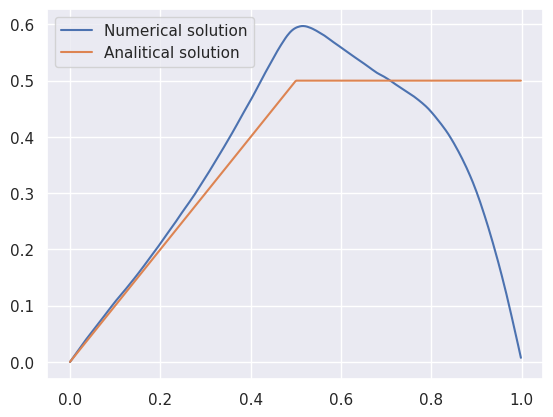

In [13]:
alpha = 1e-2
left_matrix = (alpha * D + np.diag(np.ones(n + 1)))@(alpha * D + np.diag(np.ones(n + 1))) 
T = u2(np.linspace(0, 1, n + 1))

f_epsilon = np.linalg.inv(left_matrix) @ D @ T

plt.plot(np.linspace(0, 1, n + 1)[:-1], f_epsilon[:-1], label="Numerical solution")
plt.plot(np.linspace(0, 1, n + 1)[:-1], f(np.linspace(0, 1, n + 1))[:-1], label="Analitical solution")
plt.legend()

Стало сильно лучше, картинку конкретно колбасит, но динамику она передает.